### Install dependencies - Not Needed On Colab


In [9]:
!pip install wordcloud pandas torch transformers scikit-learn matplotlib wordcloud numpy accelerate>=0.26.0

### Import all the libraries we'll use in this project

In [10]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import random

### Create fake insurance claim data to practice with
### This is like making up examples of what people might say when filing claims


In [11]:
data = {
    "description": [
        "My car was damaged in a collision.",
        "The roof of my house leaked after a storm.",
        "I need to file a claim for my recent surgery.",
        "My vehicle was stolen from the parking lot.",
        "A fire damaged my kitchen.",
        "I broke my leg while hiking.",
        "My windshield cracked due to hail.",
        "My basement flooded after heavy rain.",
        "I was hospitalized for pneumonia.",
        "My bike was hit by a car.",
        "My house was burglarized last night.",
        "I need reimbursement for my dental procedure.",
        "A tree fell on my garage.",
        "I was injured in a car accident.",
        "My health insurance should cover my medication.",
        "My car was rear-ended at a stoplight.",
        "Water damage ruined my living room carpet.",
        "I need to claim for my knee surgery.",
        "My motorcycle was vandalized.",
        "A pipe burst in my bathroom."
    ],
    "category": [
        "auto", "home", "health", "auto", "home", "health", "auto", "home", "health", "auto",
        "home", "health", "home", "auto", "health", "auto", "home", "health", "auto", "home"
    ]
}

# Put our data into a DataFrame so it's easier to work with
df = pd.DataFrame(data)

# Convert text categories into numbers that the computer can understand
# The LabelEncoder turns "auto", "home", "health" into 0, 1, 2
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

# Break down the text into tokens (smaller pieces) that DistilBERT can understand
# This is like teaching the computer how to read each word
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(df['description'].tolist(), truncation=True, padding=True, max_length=32)

# Create a custom dataset class that PyTorch can use for training
# This organizes our data in a way the model expects
class ClaimsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Get one example from our dataset
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        # Tell PyTorch how many examples we have
        return len(self.labels)

# Create our dataset using the tokenized text and labels
dataset = ClaimsDataset(encodings, df['label'].tolist())

# Split our data into training and testing sets
# We'll use most data to teach the model, and save some to test how well it learned
def train_test_split(dataset, test_size=0.2, seed=42):
    np.random.seed(seed)  # Make sure we get the same split every time
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    split = int(len(dataset) * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    return torch.utils.data.Subset(dataset, train_idx), torch.utils.data.Subset(dataset, test_idx)

train_dataset, test_dataset = train_test_split(dataset)

# Set up our DistilBERT model for classification
# We're using a pre-trained model and adapting it for our 3 categories
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=len(le.classes_)
)

# Configure how we want to train the model
# These settings control things like how long to train and batch sizes
training_args = TrainingArguments(
    output_dir='./results',          # Where to save results
    num_train_epochs=3,              # How many times to go through all the data
    per_device_train_batch_size=4,   # How many examples to process at once during training
    per_device_eval_batch_size=4,    # How many examples to process at once during testing
    logging_dir='./logs',            # Where to save training logs
    logging_steps=5,                 # How often to record progress
    eval_strategy="epoch",           # Test the model after each epoch
    save_strategy="no"               # Don't save checkpoints (saves space)
)

# Create the trainer that will handle the training process
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model on our insurance claims data
# This is where the computer learns to recognize patterns
print("Starting training...")
trainer.train()
print("Training completed!")

# Test how well our model performs on data it hasn't seen before
print("Making predictions on test data...")
preds = trainer.predict(test_dataset)
y_true = [test_dataset[i]['labels'].item() for i in range(len(test_dataset))]
y_pred = np.argmax(preds.predictions, axis=1)

# # Create a confusion matrix to see which categories the model gets right or wrong
# # This shows us exactly where our model makes mistakes


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


C:\Users\Temi\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,1.040726
2,1.085900,0.972381
3,0.839700,0.928459


Training completed!
Making predictions on test data...


### Create a confusion matrix to see which categories the model gets right or wrong
### This shows us exactly where our model makes mistakes

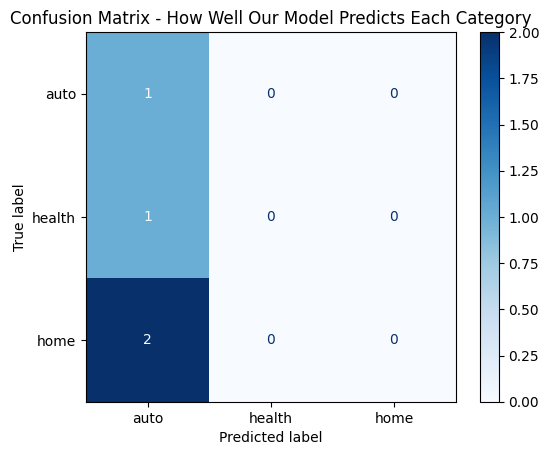

In [12]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - How Well Our Model Predicts Each Category")
plt.show()


### Create word clouds to visualize the most common words in each category
### This helps us see what words are typical for each type of claim

Creating word clouds for each category...


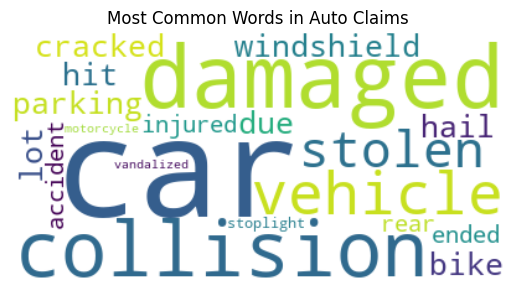

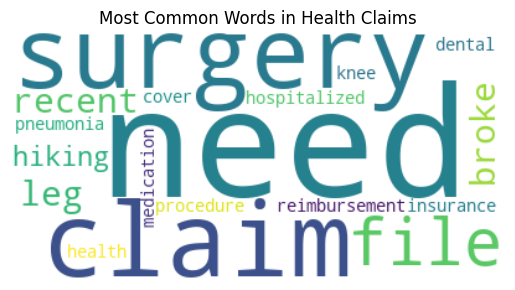

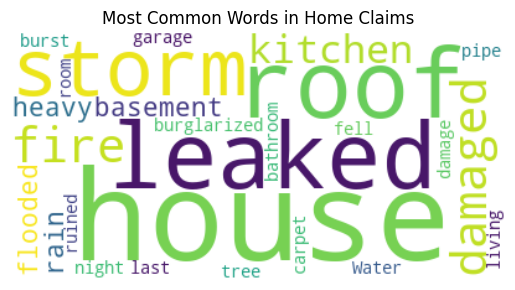


Testing our model with a new claim:
Claim: 'My car was hit by another vehicle while parked.'
Predicted category: auto

Project completed! The model can now classify insurance claims into auto, home, or health categories.


In [13]:
print("Creating word clouds for each category...")
for category in le.classes_:
    # Combine all descriptions for this category into one big text
    text = " ".join(df[df['category'] == category]['description'])
    
    # Generate a word cloud showing the most frequent words
    wc = WordCloud(width=400, height=200, background_color='white').generate(text)
    
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Most Common Words in {category.capitalize()} Claims")
    plt.axis('off')  # Hide the axes since this is just a picture
    plt.show()

# Create a function to predict the category of new insurance claims
def predict_claim(text):
    """
    Takes a claim description and predicts which category it belongs to
    """
    # Convert the text into tokens the model can understand
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
    
    # Get the model's prediction
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    
    # Convert the number prediction back to a category name
    return le.inverse_transform([pred])[0]

# Test our model with a new example claim
example_claim = "My car was hit by another vehicle while parked."
print(f"\nTesting our model with a new claim:")
print(f"Claim: '{example_claim}'")
print(f"Predicted category: {predict_claim(example_claim)}")

print("\nProject completed! The model can now classify insurance claims into auto, home, or health categories.")